In [ ]:
# 1D Conv layers since input and output shapes are 2D

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, Sequential, Conv1d, MaxPool1d, Module, Softmax, BatchNorm1d, Dropout, BCEWithLogitsLoss
from torch.optim import SGD, Adam

In [5]:
from PTBXLDataLoader import PTBXLDataLoader

loader = PTBXLDataLoader()
train_inputs, train_labels, val_inputs, val_labels, test_inputs, test_labels, classes = loader.load_data()

100%|██████████| 21388/21388 [00:28<00:00, 741.61it/s]


In [88]:
x_train = torch.from_numpy(train_inputs.astype('float32'))
y_train = torch.from_numpy(train_labels.to_numpy().astype('float32'))
x_val = torch.from_numpy(val_inputs.astype('float32'))
y_val = torch.from_numpy(val_labels.to_numpy().astype('float32'))
x_test = torch.from_numpy(test_inputs.astype('float32'))
y_test = torch.from_numpy(test_labels.to_numpy().astype('float32'))


def standardize(x):
    x -= x.mean(0, keepdim=True)
    x /= x.std(0, unbiased=False, keepdim=True)
    return x

x_train = standardize(x_train)
x_test = standardize(x_test)
x_val = standardize(x_val)

num_classes = len(classes)

In [107]:
class NeuralNet(Module):

    def __init__(self):
        super(NeuralNet, self).__init__()

        self.cnn = Sequential(
            Conv1d(1000, 64, kernel_size=2, stride=1, padding=1),
            BatchNorm1d(64),
            ReLU(inplace=True),
            MaxPool1d(kernel_size=2, stride=2),
            Dropout(0.1),
            Conv1d(64, 128, kernel_size=2, stride=2, padding=1),
            BatchNorm1d(128),
            ReLU(inplace=True),
            MaxPool1d(kernel_size=2, stride=2),
            Dropout(0.1),
            Conv1d(128, 256, kernel_size=2, stride=1, padding=1),
            BatchNorm1d(256),
            ReLU(inplace=True),
            MaxPool1d(kernel_size=2, stride=2),
            Dropout(0.1),
            Conv1d(256, 256, kernel_size=2, stride=1, padding=1),
            BatchNorm1d(256),
            ReLU(inplace=True),
            MaxPool1d(kernel_size=2, stride=2),
            Dropout(0.1),
        )

        self.linear = Sequential(
            Linear(256, 128),
            ReLU(inplace=True),
            Dropout(0.1),
            Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [103]:
model = NeuralNet()

# hyperparams
num_epochs = 30
learning_rate = 0.05
momentum = 0.9
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = Adam(model.parameters(), lr=learning_rate)
loss = BCEWithLogitsLoss()


In [108]:

train_losses = []
val_losses = []

def train(x_train, x_val, y_train, y_val, epoch):
    
    model.train()

    tr_loss = 0

    x_train, y_train = Variable(x_train), Variable(y_train)
    x_val, y_val = Variable(x_val), Variable(y_val)

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = loss(output_train, y_train)
    loss_val = loss(output_val, y_val)

    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()

    tr_loss = loss_train.item()

    if (epoch + 1) % 10 == 0 or not epoch:
        # printing the validation loss
        print('Epoch : ', epoch + 1, '\t', 'loss :', loss_val)


for epoch in range(num_epochs):
    train(x_train, x_val, y_train, y_val, epoch)

Epoch :  1 	 loss : tensor(0.5230, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Epoch :  10 	 loss : tensor(0.5192, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Epoch :  20 	 loss : tensor(0.5126, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Epoch :  30 	 loss : tensor(0.5125, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


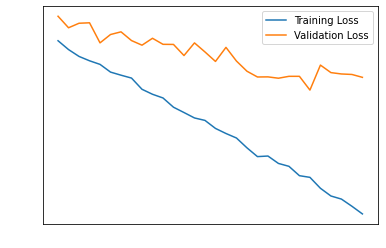

In [109]:
train_loss = [t.item() for t in train_losses]
val_loss = [t.item() for t in val_losses]

plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.tick_params(colors='white')
plt.legend()
plt.show()

In [110]:
with torch.no_grad():
    output = model(x_test)

threshold = 0.5
predictions = torch.sigmoid(output)
preds = (predictions > threshold).type(torch.uint8)
accuracy = (preds == y_test).sum() / (preds.shape[0] * preds.shape[1]) * 100
print(accuracy)


tensor(75.4495)
